# Tutorial 4 – A trained generative model with a few qubits

Welcome back to our tutorial on generative modeling with quantum hardware. In this tutorial, we will optimize the parameters of a quantum circuit generative model and find out which role entanglement plays for learning complicated data distributions.

So far, we have learned that, in a generative machine learning task, you receive data and the goal is to learn a model of the true distribution underlying the data. Then, you want to be able to generate new data from this model, which has similar characteristics, but is not necessarily inside the training set.

Lets get started and import the necessary Python tools.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer

## Recap: Defining a quantum circuit generative model and the dataset

Last time, we introduced a quantum circuit generative model which encodes probability distributions over discrete data. Particularly, the data are binary qubit measurements $x$, e.g. $x = 0000, 0001, 0010, ... ,1111$ for $n=4$ qubits. The probability $p_{model}(x)$ can formally be written as
$ |\langle x | \psi(\theta) \rangle|^2 $
where $\theta$ are the parameters of a parametrized quantum circuit which prepares the quantum state $\psi(\theta)$. In practice, this represents the probability of obtaining the outcome $x$ when you measure the prepared quantum state.

Let us recollect the function that flexibly constructs a quantum circuit with any number of qubits $n$ and layers $d$:

In [3]:
def get_circuit(number_of_qubits, number_of_layers):

    number_of_parameters = 2 * number_of_qubits * number_of_layers
    thetas = [Parameter(r"$\theta$" + f"{ii+1}") for ii in range(number_of_parameters)]

    # initialize the qiskit circuit
    circuit = QuantumCircuit(number_of_qubits)

    parameter_counter = 0

    # loop over the layers of the quantum circuit
    for l in range(number_of_layers):

        # apply a layer of RX rotations
        for n in range(number_of_qubits):
            circuit.rx(thetas[parameter_counter], n)
            parameter_counter += 1

        # apply a layer of RZ rotations
        for n in range(number_of_qubits):
            circuit.rz(thetas[parameter_counter], n)
            parameter_counter += 1

        # apply a layer of CNOTs
        for n in range(number_of_qubits - 1):
            circuit.cnot(n, n + 1)

    # instructions to measure all qubits
    circuit.measure_all()

    return circuit

For  $n=4$ and $d=2$, the quantum circuit looks like this:

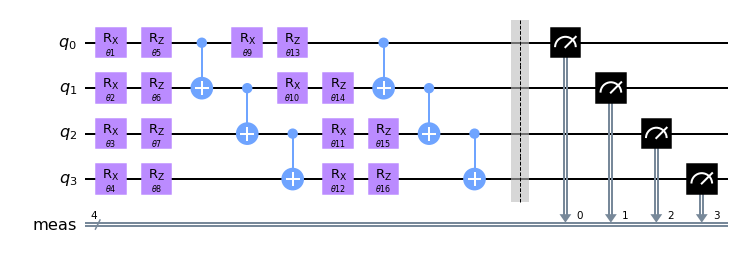

In [4]:
number_of_qubits = 4
number_of_layers = 2

circuit = get_circuit(number_of_qubits, number_of_layers)
circuit.draw("mpl")

The dataset that we constructed last time was a discretized version of the dataset used in Part 1 and Part 2 of our tutorial series:

In [5]:
training_data_dict = {
    "0000": 1,
    "0001": 0,
    "0010": 2,
    "0011": 4,
    "0100": 4,
    "0101": 10,
    "0110": 7,
    "0111": 9,
    "1000": 7,
    "1001": 5,
    "1010": 3,
    "1011": 8,
    "1100": 14,
    "1101": 19,
    "1110": 6,
    "1111": 1,
}

# normalize the counts to be interpreted as probabilities
count_sum = sum(training_data_dict.values())
for x, prob in training_data_dict.items():
    training_data_dict[x] = prob / count_sum

print(training_data_dict)

{'0000': 0.01, '0001': 0.0, '0010': 0.02, '0011': 0.04, '0100': 0.04, '0101': 0.1, '0110': 0.07, '0111': 0.09, '1000': 0.07, '1001': 0.05, '1010': 0.03, '1011': 0.08, '1100': 0.14, '1101': 0.19, '1110': 0.06, '1111': 0.01}


For convenience, let us define a function to get samples from our model given a circuit and a vector of parameters.

In [6]:
simulator = Aer.get_backend("aer_simulator")


def get_model_dict(circuit, parameters):
    # bind the circuit parameters to numbers
    circuit_with_params = circuit.bind_parameters(parameters)

    # run the circuit and get the result

    result = simulator.run(circuit_with_params, shots=10000).result()

    # extract the measurement counts as a python dictionary
    model_dict = result.get_counts()

    return model_dict

With a random initial guess for our parameter vector $\theta$, we can plot the quantum circuit model distribution together with the dataset.

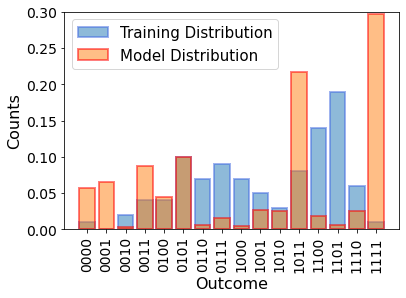

In [7]:
np.random.seed(42)

# the quantum circuit has 2*n*d parameters
number_of_parameters = 2 * number_of_qubits * number_of_layers

# define value for the initial parameters
parameters = np.random.uniform(0, 2 * np.pi, size=number_of_parameters)

# get the model dict using our function
model_dict = get_model_dict(circuit, parameters)

# for convenience sort by binary order
model_dict = dict(sorted(model_dict.items()))

# do the plotting
fig, ax = plt.subplots(1, 1)

plt.bar(
    training_data_dict.keys(),
    np.array(list(training_data_dict.values()))
    / sum(training_data_dict.values()),  # turn the counts into probabilities
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Distribution",
)
plt.bar(
    model_dict.keys(),
    np.array(list(model_dict.values()))
    / sum(model_dict.values()),  # turn the counts into probabilities
    alpha=0.5,
    edgecolor="red",
    linewidth=2,
    label="Model Distribution",
)

plt.xticks(rotation="vertical")
plt.legend(fontsize=15)
ax.set_ylabel("Counts", fontsize=16)
ax.set_xlabel("Outcome", fontsize=16)
ax.tick_params(labelsize=14)
plt.ylim(0, 0.30)
plt.show()

A crucial component of our generative modeling task is the loss function that we optimize to learn the data. Here, we use the KL divergence 

$$\text{KL}(p_{data}, p_{model}) = \sum_{x\sim \mathcal{D}} \left[ p_{data}(x) \log(p_{data}(x)) - p_{data}(x) \log(p_{model}(x)) \right]$$

which measures the similarity between data generated from our model and from the dataset. The KL divergence approaches $0$ if the distributions match perfectly, i.e.,  $p_{data} = p_{model}$. 

In [8]:
def kl_divergence(data_distribution, model_distribution):
    # we will require a small offset "e" to avoid possible log(0) singularities
    e = 1e-6

    # make sure the values in the dictionaries add up to 1
    sum_data = sum(data_distribution.values())
    sum_model = sum(model_distribution.values())
    for bin_outcome, count in data_distribution.items():
        data_distribution[bin_outcome] = max(count / sum_data, e)
    for bin_outcome, count in model_distribution.items():
        model_distribution[bin_outcome] = max(count / sum_model, e)

    # calculate the first term in the KL divergence formula
    term1 = 0
    for bin_outcome, prob in data_distribution.items():
        term1 += prob * np.log(prob)

    # calculate the second term in the KL divergence formula
    term2 = 0
    for bin_outcome, prob in data_distribution.items():
        term2 += prob * np.log(model_distribution.get(bin_outcome, e))

    return term1 - term2

For our random initial parameter guess we can estimate the KL divergence value and obtain:

In [9]:
kl_divergence(training_data_dict, model_dict)

1.4231586563831473

## Optimizing a quantum circuit generative model

Our goal now is to optimize the parameters of the quantum circuit with the goal of lowering the KL divergence. One approach for doing that is via *gradient descent*. Similarly to Part 2 of this tutorial series, we define a simple function to estimate a numerical gradient of the KL divergence using finite differences:

$$ grad(\text{KL})(x) \equiv \nabla \text{KL}(x) \approx \frac{\text{KL}(x+\epsilon) - \text{KL}(x+\epsilon)}{2\epsilon} $$

with a small $\epsilon$ (epsilon).

In [10]:
def calculate_gradient(model_parameters, circuit, finite_distance_eps):
    gradient_vector = np.zeros(len(model_parameters))

    # loop over all parameters
    for kk in range(len(model_parameters)):
        # define the eps vector in the direction of the parameter
        delta_vector = np.zeros(len(model_parameters))
        delta_vector[kk] = finite_distance_eps

        # add or subtract eps from the parameter
        params_plus = model_parameters + delta_vector
        params_minus = model_parameters - delta_vector

        # get the corresponding measurements from the quantum circuit
        model_dict_plus = get_model_dict(circuit, params_plus)
        model_dict_minus = get_model_dict(circuit, params_minus)

        # calculate the KL divergence values
        kl_plus = kl_divergence(training_data_dict, model_dict_plus)
        kl_minus = kl_divergence(training_data_dict, model_dict_minus)

        # calculate the finite difference gradient
        gradient = (kl_plus - kl_minus) / (2 * finite_distance_eps)
        gradient_vector[kk] = gradient

    return gradient_vector

This time, we choose $\epsilon = 0.05$, which is a little larger than last time. We do this because we want to be able to confidently differentiate the two evaluations of the model at $2\epsilon$ different parameters with a finite number of samples from the quantum computer.

In [11]:
eps = 5e-2

And as in Part 2, we define a simple gradient descent algorithm via

$$ \theta^{(t+1)} = \theta^{(t)} - \eta\cdot \nabla\text{KL}(x; \theta^{(t)}),$$

with a _learning rate_ $\eta$ (eta), where $t$ is the training iteration index.

In [12]:
# to keep track of the progress
from tqdm import tqdm

In [13]:
%%time

# generate initial random parameters
np.random.seed(42)
parameters = np.random.uniform(0, 2 * np.pi, size=number_of_parameters)

# learning rate and number of iterations
learning_rate = 0.1
T = 100

all_kls = []

# evaluate and record the initial KL divergence loss
model_dict = get_model_dict(circuit, parameters)
all_kls.append(kl_divergence(training_data_dict, model_dict))

# train!
for t in tqdm(range(T)):
    # one gradient descent step
    gradient_vector = calculate_gradient(parameters, circuit, eps)
    parameters -= learning_rate * gradient_vector

    # evaluate and record the KL divergence loss
    model_dict = get_model_dict(circuit, parameters)
    all_kls.append(kl_divergence(training_data_dict, model_dict))


final_parameters = parameters.copy()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]

CPU times: total: 1min 9s
Wall time: 1min 9s


And plot up the optimization results:

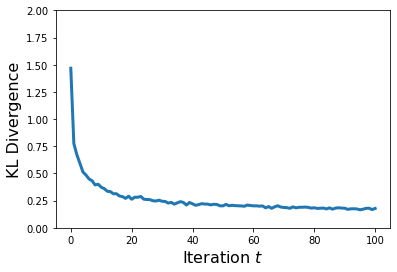

In [14]:
fig, ax = plt.subplots(1, 1)

plt.plot(all_kls, linewidth=3)

ax.set_ylabel("KL Divergence", fontsize=16)
ax.set_xlabel("Iteration $t$", fontsize=16)
plt.ylim(0, 2)
plt.show()

This is a lot of improvement in terms of the KL divergence! To visually confirm that the freshly optimized model represents the data distribution much better, let us plot the model distribution together with the training data.

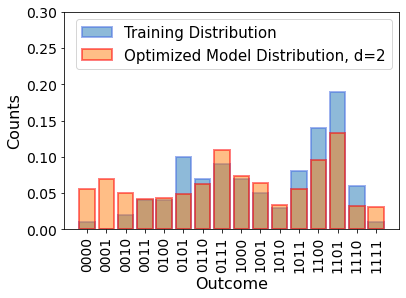

In [15]:
np.random.seed(42)

# get the model dict using our function
model_dict = get_model_dict(circuit, final_parameters)

# for convenience sort by binary order
model_dict = dict(sorted(model_dict.items()))

# do the plotting
fig, ax = plt.subplots(1, 1)

x_points = np.linspace(-1.5, 1.5, 1000)

plt.bar(
    training_data_dict.keys(),
    np.array(list(training_data_dict.values()))
    / sum(training_data_dict.values()),  # turn the counts into probabilities
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Distribution",
)
plt.bar(
    model_dict.keys(),
    np.array(list(model_dict.values()))
    / sum(model_dict.values()),  # turn the counts into probabilities
    alpha=0.5,
    edgecolor="red",
    linewidth=2,
    label="Optimized Model Distribution, d=2",
)

plt.xticks(rotation="vertical")
plt.legend(fontsize=15)
ax.set_ylabel("Counts", fontsize=16)
ax.set_xlabel("Outcome", fontsize=16)
ax.tick_params(labelsize=14)
plt.ylim(0, 0.30)
plt.show()

This model distribution resembles the training data distribution pretty well, and our trained quantum circuit could already be used as a generative model.

But let us take a few steps back and think about about the structure of the quantum circuit and how it may affect performance.

## The role of entanglement

Remember that we defined the number of layers $d=2$, which gave us the circuit layout that you can see above. How would this all have worked if we used $d=1$, i.e., only one layer of entangling *CNOT* gates? This exploration is similar to our QML 104 tutorial, which you can find [here](https://alqor.io/tutorials/a-beginners-guide-to-quantum-machine-learning).

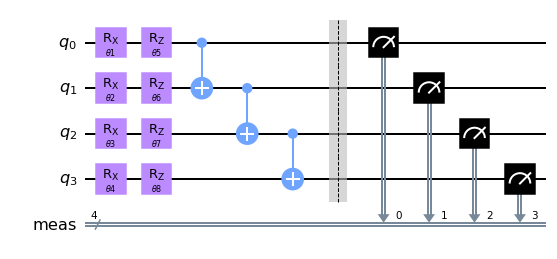

In [16]:
number_of_layers = 1

circuit1 = get_circuit(number_of_qubits, number_of_layers)
circuit1.draw("mpl")

Train it ...

In [17]:
%%time

number_of_parameters1 = 2 * number_of_qubits * number_of_layers

# generate initial random parameters
np.random.seed(42)
parameters = np.random.uniform(0, 2 * np.pi, size=number_of_parameters1)

# learning rate and number of iterations
learning_rate = 0.1
T = 100

all_kls1 = []

# evaluate and record the initial KL divergence loss
model_dict = get_model_dict(circuit1, parameters)
all_kls1.append(kl_divergence(training_data_dict, model_dict))

# train!
for t in tqdm(range(T)):
    # one gradient descent step
    gradient_vector = calculate_gradient(parameters, circuit1, eps)
    parameters -= learning_rate * gradient_vector

    # evaluate and record the KL divergence loss
    model_dict = get_model_dict(circuit1, parameters)
    all_kls1.append(kl_divergence(training_data_dict, model_dict))


final_parameters1 = parameters.copy()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]

CPU times: total: 35 s
Wall time: 35.1 s


... and plot it together with the previous run with $d=2$:

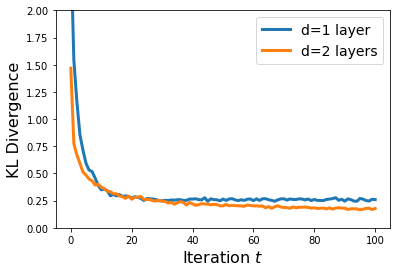

In [18]:
fig, ax = plt.subplots(1, 1)

plt.plot(all_kls1, linewidth=3, label="d=1 layer")
plt.plot(all_kls, linewidth=3, label="d=2 layers")

ax.set_ylabel("KL Divergence", fontsize=16)
ax.set_xlabel("Iteration $t$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(0, 2)
plt.show()

We can see that $d=2$ reaches slightly better KL divergence values than $d=1$. Let's try the more adventurous $d = 5$ and compare.

In [19]:
number_of_layers = 5

circuit5 = get_circuit(number_of_qubits, number_of_layers)

In [20]:
%%time

number_of_parameters5 = 2 * number_of_qubits * number_of_layers

# generate initial random parameters
np.random.seed(42)
parameters = np.random.uniform(0, 2 * np.pi, size=number_of_parameters5)

# learning rate and number of iterations
learning_rate = 0.1
T = 100

all_kls5 = []

# evaluate and record the initial KL divergence loss
model_dict = get_model_dict(circuit5, parameters)
all_kls5.append(kl_divergence(training_data_dict, model_dict))

# train!
for t in tqdm(range(T)):
    # one gradient descent step
    gradient_vector = calculate_gradient(parameters, circuit5, eps)
    parameters -= learning_rate * gradient_vector

    # evaluate and record the KL divergence loss
    model_dict = get_model_dict(circuit5, parameters)
    all_kls5.append(kl_divergence(training_data_dict, model_dict))


final_parameters5 = parameters.copy()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]

CPU times: total: 3min 20s
Wall time: 3min 21s


Plot up all KL divergences that we collected:

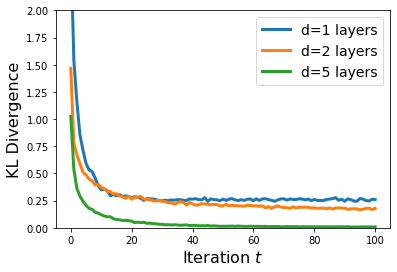

In [21]:
fig, ax = plt.subplots(1, 1)

plt.plot(all_kls1, linewidth=3, label="d=1 layers")
plt.plot(all_kls, linewidth=3, label="d=2 layers")
plt.plot(all_kls5, linewidth=3, label="d=5 layers")

ax.set_ylabel("KL Divergence", fontsize=16)
ax.set_xlabel("Iteration $t$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(0, 2)
plt.show()

$d=5$ enables the KL divergence to go much lower, and approach the perfect value of $KL = 0$. The corresponding model distribution looks like this:

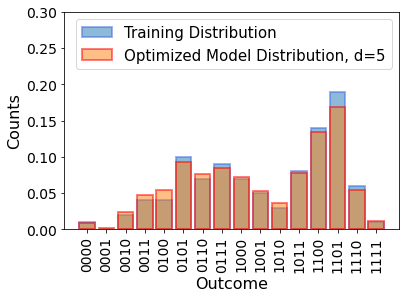

In [22]:
np.random.seed(42)

# get the model dict using our function
model_dict = get_model_dict(circuit5, final_parameters5)

# for convenience sort by binary order
model_dict = dict(sorted(model_dict.items()))

# do the plotting
fig, ax = plt.subplots(1, 1)

plt.bar(
    training_data_dict.keys(),
    np.array(list(training_data_dict.values()))
    / sum(training_data_dict.values()),  # turn the counts into probabilities
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Distribution",
)
plt.bar(
    model_dict.keys(),
    np.array(list(model_dict.values()))
    / sum(model_dict.values()),  # turn the counts into probabilities
    alpha=0.5,
    edgecolor="red",
    linewidth=2,
    label="Optimized Model Distribution, d=5",
)

plt.xticks(rotation="vertical")
plt.legend(fontsize=15)
ax.set_ylabel("Counts", fontsize=16)
ax.set_xlabel("Outcome", fontsize=16)
ax.tick_params(labelsize=14)
plt.ylim(0, 0.30)
plt.show()

This really is a much better fit on the training distribution $p_{data}$, just as the low KL divergence indicated. But why? Is it just the additional parameters $\theta$ in the quantum circuit with more layers? No! In fact, without any entangling gates, the additional parameters would be redundant. What makes this quantum circuit model powerful (also called more *expressive*) is the entangling gates sandwiched between parametrized single-qubit gates. Lets think about this on the level of a two-qubit *wavefunction*.


## Optional discussion on entanglement

**NOTE: If the following calculation is too involved for you, don't worry! You will be still be able to take away the most important message.**

Assume that you want to learn the target distribution that contains $50\%$ $00$ and $50\%$ $11$. You might notice that this is the distribution that you would expect if you measured a *Bell state*. See our recent tutorial on this very special state [here](bell).

A general two-qubit wavefunction can be written as:

$$
|\psi\rangle = \alpha_{00}|00\rangle + \alpha_{01}|01\rangle + \alpha_{10}|10\rangle + \alpha_{00}|11\rangle
$$

where all $\alpha$ are complex numbers and their absolute squares $|\alpha|^2$ add up to $1$. If the two qubits are not entangled, then by definition, you can split up the state of both qubits into the product of the individual states:

$$
|\psi\rangle = |\psi\rangle_1 \otimes |\psi\rangle_2
$$

Writing each state with it's own amplitudes $\alpha^{(1)}$ and $\alpha^{(2)}$, respectively, we can write

$$
|\psi\rangle = (\alpha^{(1)}_0|0\rangle_1 + \alpha^{(1)}_1|1\rangle_1) \otimes (\alpha^{(2)}_0|0\rangle_2 + \alpha^{(2)}_1|1\rangle_2)
$$

**Question**: Can you find a combination of $\alpha^{(1)}_0, \alpha^{(1)}_1, \alpha^{(2)}_0, \alpha^{(2)}_1$ such that you can multiply the terms back together and achieve $|\alpha^{(1)}_0 \alpha^{(2)}_0|^2 = |\alpha^{(1)}_1 \alpha^{(2)}_1|^2 = 0.5$, and all other terms are $0$? Such a state would create the desired target distribution.

No, that is not possible! You need at least one *CNOT* gate, that entangles the two qubits.

The important message is: 
**Without any entangling gates, you are very restricted in the distributions $p_{model}$ that you can attain. And inversely, increasing the number of entangling gates in your quantum circuit allows you to model increasingly complicated distributions.**

## Conclusion

Quantum circuit generative models utilize the phenomena of entanglement and wavefunction collapse (i.e., the measurement) as a resource, and are thus promissing candidates for efficiently learning and sampling from complicated discrete probability distributions. In this tutorial, you learned how to train a quantum circuit generative model using the KL divergence loss function, and how more entanglement enables the model to learn continuously better models of the training data distribution.
\
\
But there is much more to learn. For example, to we really want to reach $KL = 0$ on the training dataset? Can more entanglement be detrimental for training? How do you choose a good ansatz for a particular dataset? Does KL divergence training scale well as we increase the number of qubits? And much more...
\
\
Stay tuned for our next and final tutorial in the series of *Generative Modeling with Quantum Hardware*, where we explore cutting edge research in the domain quantum circuit generative models. See you soon!